<a href="https://colab.research.google.com/github/sujitojha1/EVA8/blob/main/Session4/EVA8_S4_step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 2
### Target
1. Add image augmentation w random rotation and random affine to improve the model performance.


In [37]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [38]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [39]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [40]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


## Model

In [41]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=1, bias=False),
        ) # output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 2
        
        # # OUTPUT BLOCK
        # self.gap = nn.Sequential(
        #     nn.AvgPool2d(kernel_size=6)
        # ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.fc = nn.Sequential(
            nn.Linear(90, 10)
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        # x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

## Model Params

In [42]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0

## Training and Testing

In [43]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [44]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.18555013835430145 Batch_id=468 Accuracy=92.50: 100%|██████████| 469/469 [00:25<00:00, 18.12it/s]



Test set: Average loss: 0.0646, Accuracy: 9778/10000 (97.78%)

EPOCH: 1


Loss=0.07898318767547607 Batch_id=468 Accuracy=96.88: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]



Test set: Average loss: 0.0568, Accuracy: 9819/10000 (98.19%)

EPOCH: 2


Loss=0.08888707309961319 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]



Test set: Average loss: 0.0470, Accuracy: 9837/10000 (98.37%)

EPOCH: 3


Loss=0.01578996516764164 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]



Test set: Average loss: 0.0343, Accuracy: 9882/10000 (98.82%)

EPOCH: 4


Loss=0.06700942665338516 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]



Test set: Average loss: 0.0314, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Loss=0.042668845504522324 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:19<00:00, 23.77it/s]



Test set: Average loss: 0.0312, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.025402924045920372 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]



Test set: Average loss: 0.0306, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.10389995574951172 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]



Test set: Average loss: 0.0298, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.03084077499806881 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]



Test set: Average loss: 0.0285, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.04562091454863548 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]



Test set: Average loss: 0.0335, Accuracy: 9894/10000 (98.94%)

EPOCH: 10


Loss=0.13179391622543335 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]



Test set: Average loss: 0.0240, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.029314668849110603 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:18<00:00, 24.83it/s]



Test set: Average loss: 0.0282, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.04670628532767296 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]



Test set: Average loss: 0.0267, Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.05850836634635925 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]



Test set: Average loss: 0.0298, Accuracy: 9902/10000 (99.02%)

EPOCH: 14


Loss=0.011055291630327702 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]



Test set: Average loss: 0.0274, Accuracy: 9913/10000 (99.13%)



Text(0.5, 1.0, 'Test Accuracy')

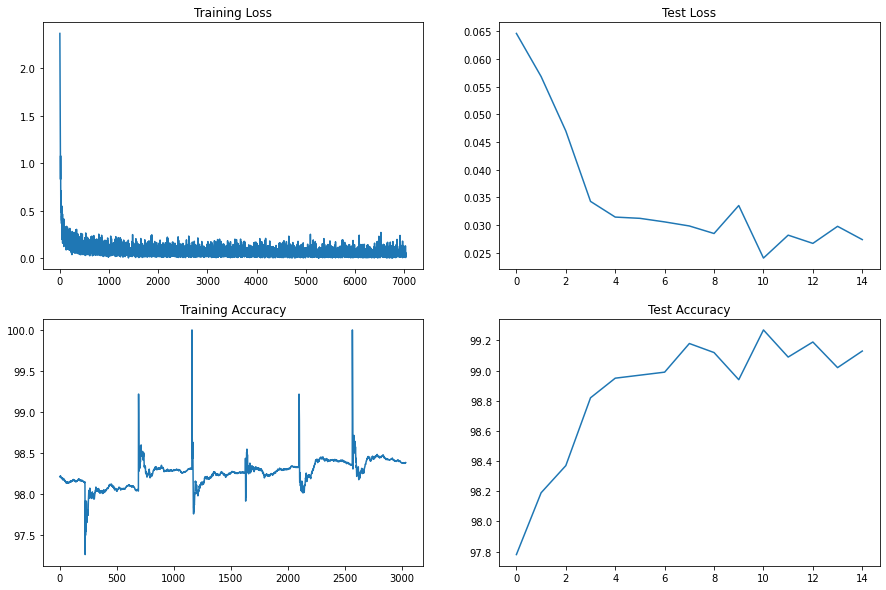

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")